In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import umap
from sklearn.manifold import TSNE

c:\Users\ninag\mambaforge\envs\math\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_norm = pd.read_csv('df/6_clear_normalised.csv')

In [3]:
# divide the data
X_norm = df_norm.drop(columns=['raw_value'], axis = 1)
Y = df_norm['raw_value']

### Linear methods of dimensionality reduction

In the lecture we were introduced to three methods of linear dimensionality reduction, among them principal component analysis (which cannot be used in the assignment), linear discriminant analysis, and independent component analysis. LDA is designed to solve classification problems, so it is not suitable for us. In ICA, the hypothesis that the components have a non-normal distribution and their sources are independent is accepted, as originally this method was used for the analysis of audio signals. This method is quite good, but it has low interpretation, which complicates the choice of the number of required components.

Therefore it was decided to use singular value decomposition (SVD) as a linear dimensionality reduction method. When selecting the number of components in SVD (as well as in PCA) we focus exactly on the cumulative variance, which the considered components give.

In [4]:
# perform SVD with 100 components
svd = TruncatedSVD(n_components = 100)
X_svd = svd.fit_transform(X_norm)

In [5]:
# calculate cumulative variance
y = np.cumsum(svd.explained_variance_ratio_)

In [6]:
# calculate principal components
xi = np.arange(1, y.shape[0]+1, step=1)

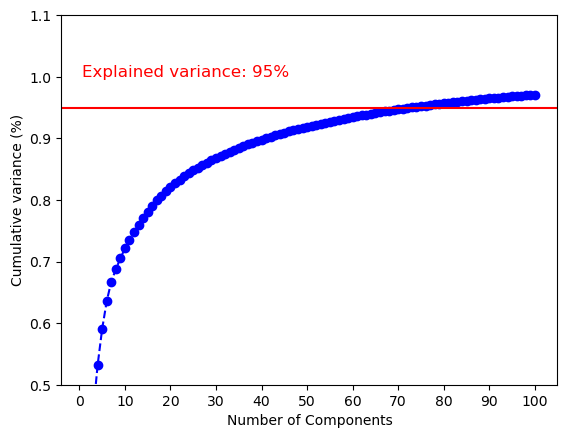

In [7]:
# plot results
plt.ylim(0.5,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 101, step=10))
plt.ylabel('Cumulative variance (%)')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 1, 'Explained variance: 95%', color = 'red', fontsize=12)
plt.show()

As we can see, 75 components is sufficient, since this is when the cumulative variance reaches 0.95.

In [8]:
# perform SVD with 75 components
svd = TruncatedSVD(n_components = 75)
X_svd = svd.fit_transform(X_norm)

In [9]:
# translate to dataframe
df_pc = pd.DataFrame(data = X_svd, columns = [f'SV{i}' for i in range(1,76)])

Let us try to partially explain the physical meaning of some obtained singular vectors by checking the correlation with the available features.

In [10]:
# combine the original data (X_pubchem) and first three PCs
df_col = pd.concat([df_pc[['SV10','SV20','SV30']], pd.DataFrame(X_norm.iloc[:,:10], columns=X_norm.iloc[:,:10].columns)], axis=1)

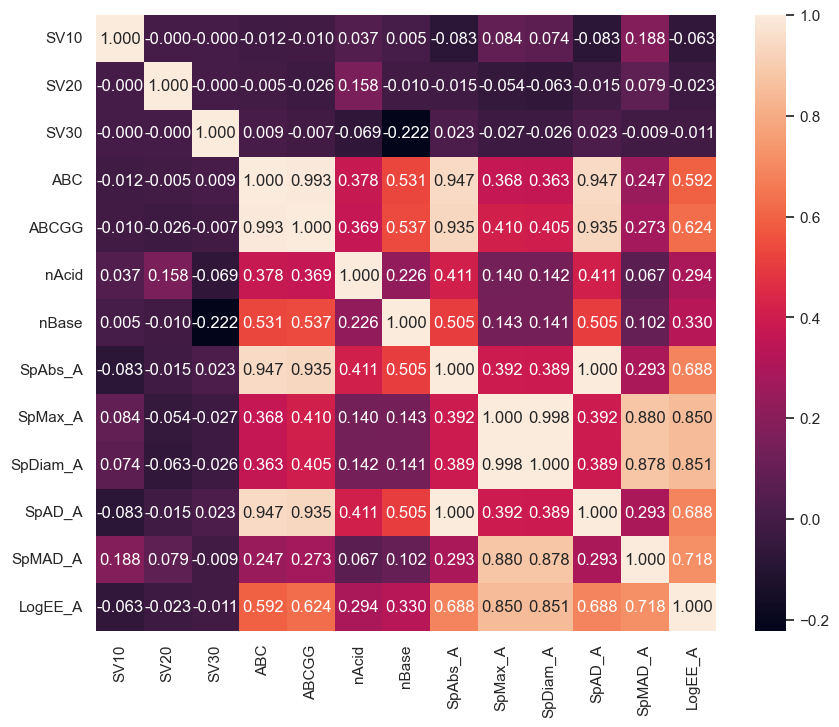

<Figure size 2800x1800 with 0 Axes>

In [11]:
# compute the correlations between the original data and SVs
corMatrix = pd.DataFrame.corr(df_col)

# plot the results
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(corMatrix, annot=True, fmt='.3f')
plt.figure(figsize=(28,18))
plt.show()

We may notice here that:
1. SV10 shows the highest value of correlation with parameter SpMAD_A
2. SV20 shows correlation with the number of acid groups
3. SV30, on the contrary, is oriented to the number of base groups. 

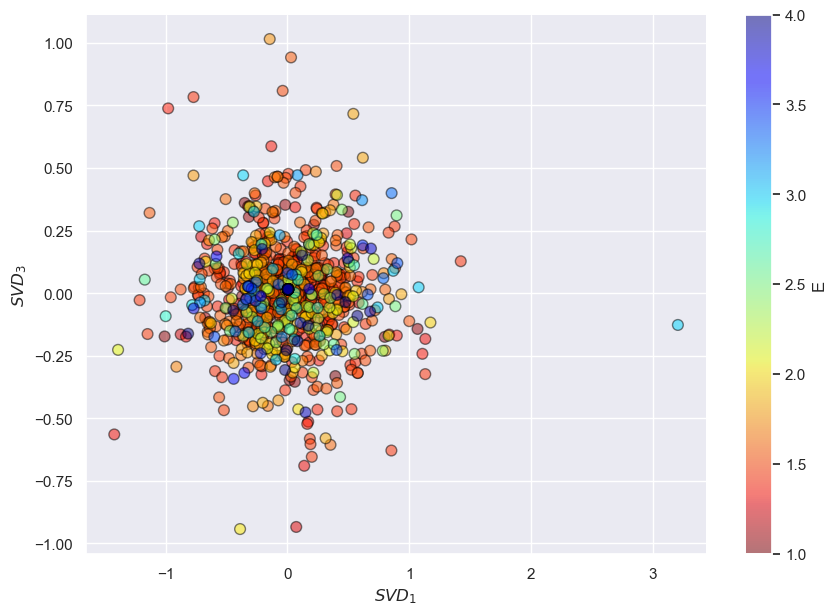

In [12]:
# plot results
fig = plt.figure(figsize=(10,7))
ax  = fig.add_subplot(111)
scatter = ax.scatter(X_svd[:, 10], X_svd[:, 30], c = Y, s=60, edgecolors='black', cmap=cm.jet_r, alpha=0.5)
colorbar = fig.colorbar(scatter, ax=ax, label = "E")
plt.xlabel(r'$SVD_1$')
plt.ylabel(r'$SVD_3$')
sns.despine()
plt.show()

As one might assume, samples are not clustered in this case, but such clustering may be possible in one of the SV combinations.

### Non-linear methods of dimensionality reduction

Among the nonlinear dimensionality reduction methods, the most suitable are T-distributed Stochastic Neighbor Embedding and Uniform Manifold Approximation and Projection, since they are designed for high dimensional data.

t-SNE is also robust to data noise, which is a definite plus. This method contains a perplexity variable. Let's try to observe the change in plots when perplexity changes.

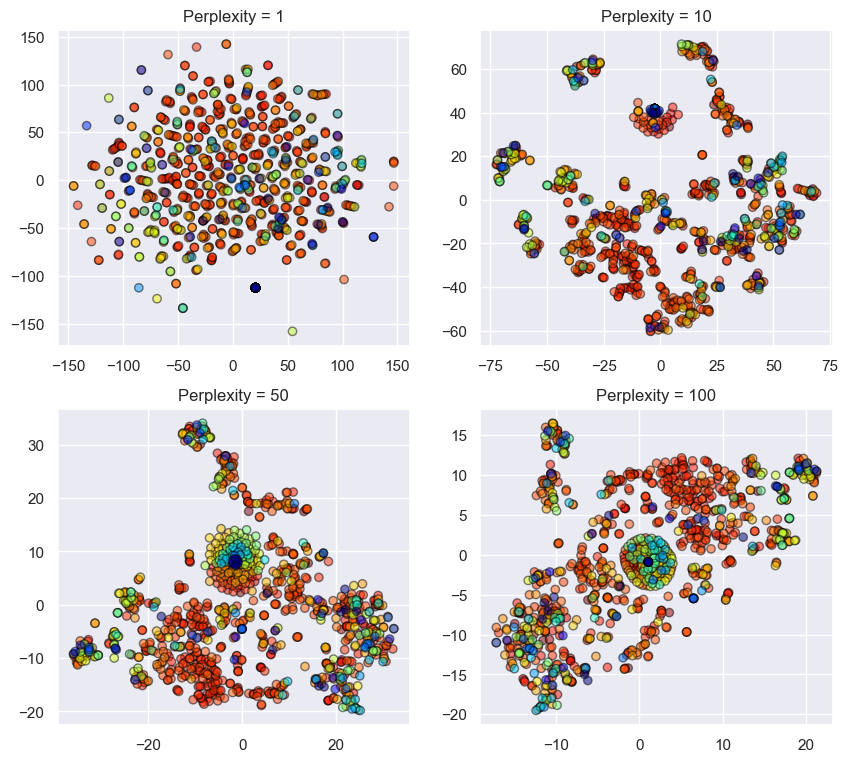

In [13]:
plt.figure(figsize = (10,5))
plt.subplots_adjust(top = 1.5)

for index, p in enumerate([1, 10, 50, 100]):

    # perform t-SNE
    tsne = TSNE(n_components = 2, perplexity = p, random_state=0)
    tsne_results = tsne.fit_transform(X_norm)
    
    tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
    
    # plot the results
    plt.subplot(2,2,index+1)
    plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=Y, edgecolors='black', cmap=cm.jet_r, alpha=0.5)
    plt.title('Perplexity = '+ str(p))

plt.show()

As we can see, as perplexity increases, the samples accumulate strongly in the center of the plot. This is probably what is called the "crowding problem" in this method, which should be solved by using the student t distribution in the SNE method. But there could probably be other reasons for this.

But still, at a perplexity value of 10 we can observe a good clustering of data.

But let's also try the UMAP method. Since it is quite sensitive to the choice of hyperparameters, let's try different variants of min_dist and n_neighbors.

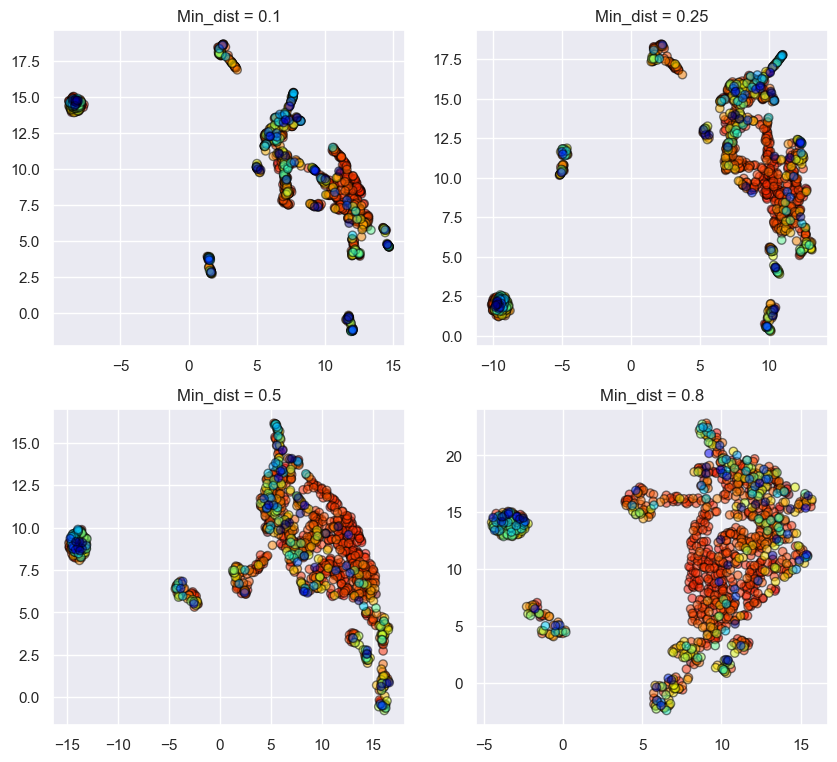

In [14]:
plt.figure(figsize = (10,5))
plt.subplots_adjust(top = 1.5)

for index, d in enumerate([0.1, 0.25, 0.5, 0.8]):

    X_umap =  umap.UMAP(n_components=2, min_dist=d, metric='manhattan').fit_transform(X_norm)
    
    u_results=pd.DataFrame(X_umap, columns=['u1', 'u2'])
    
    plt.subplot(2,2,index+1)
    plt.scatter(u_results['u1'], u_results['u2'], c=Y, edgecolors='black', cmap=cm.jet_r, alpha=0.5)
    plt.title('Min_dist = '+ str(d))
plt.show()

Here we see that with a small min_dist UMAP manages to find small connected components and clusters. When min_dist is increased, these structures are pushed into softer and more general features, providing a better overall representation of the data while losing more detail.

c:\Users\ninag\mambaforge\envs\math\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


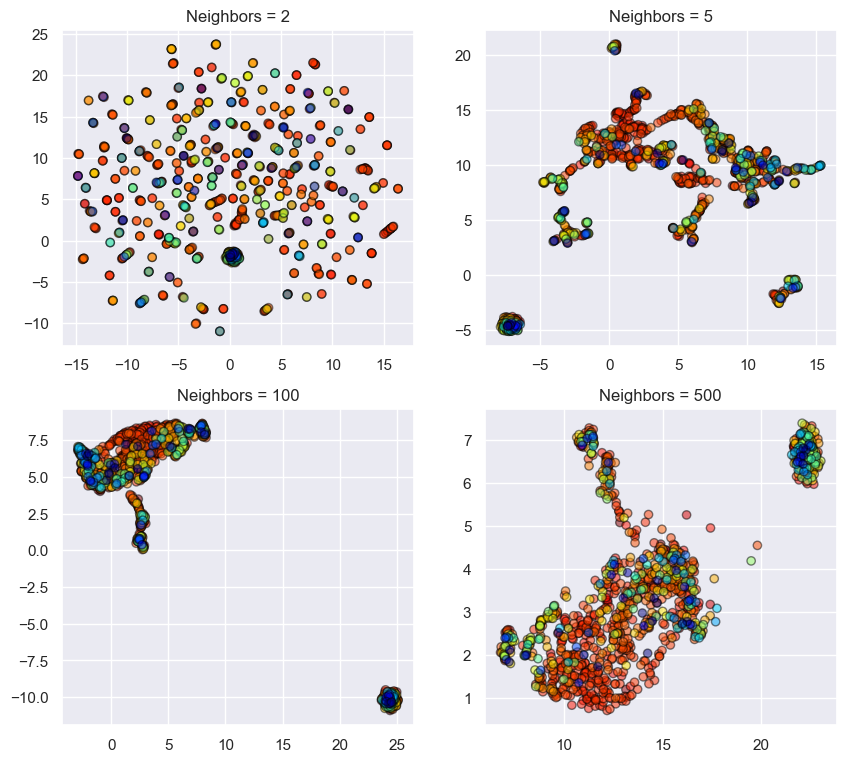

In [15]:
plt.figure(figsize = (10,5))
plt.subplots_adjust(top = 1.5)

for index, n in enumerate([2, 5, 100, 500]):

    X_umap =  umap.UMAP(n_components=2, n_neighbors=n, min_dist=0.25, metric='manhattan').fit_transform(X_norm)
    
    u_results=pd.DataFrame(X_umap, columns=['u1', 'u2'])
    
    plt.subplot(2,2,index+1)
    plt.scatter(u_results['u1'], u_results['u2'], c=Y, edgecolors='black', cmap=cm.jet_r, alpha=0.5)
    plt.title('Neighbors = '+ str(n))
plt.show()

As we can see, when neighbors = 2, the data are very disjointed, indicating that in terms of fine detail, the data are very disjointed and scattered throughout the space. As n_neighbors increases further more and more focus in placed on the overall structure of the data. 